In [62]:
!pip install pymatgen -q

In [6]:
from fastai import *
from fastai.vision.all import *
from models import SimpleAutoencoder

import sys
sys.path.append('..')
sys.path.append('resnet_autoencoder')

from src.band_plotters import *
from src.transforms import Binarize
from src.TensorImageNoised import *

from resnet_autoencoder import model

## Load

In [24]:
DataBlock.dataloaders?

Signature:
DataBlock.dataloaders(
    self,
    source,
    path: 'str' = '.',
    verbose: 'bool' = False,
    *,
    bs: 'int' = 64,
    shuffle: 'bool' = False,
    num_workers: 'int' = None,
    do_setup: 'bool' = True,
    pin_memory=False,
    timeout=0,
    batch_size=None,
    drop_last=False,
    indexed=None,
    n=None,
    device=None,
    persistent_workers=False,
    pin_memory_device='',
    wif=None,
    before_iter=None,
    after_item=None,
    before_batch=None,
    after_batch=None,
    after_iter=None,
    create_batches=None,
    create_item=None,
    create_batch=None,
    retain=None,
    get_idxs=None,
    sample=None,
    shuffle_fn=None,
    do_batch=None,
) -> 'DataLoaders'
Docstring: Create a `DataLoaders` object from `source`
File:      /usr/local/lib/python3.9/dist-packages/fastai/data/block.py
Type:      function


torch.Size([32, 3, 224, 224])

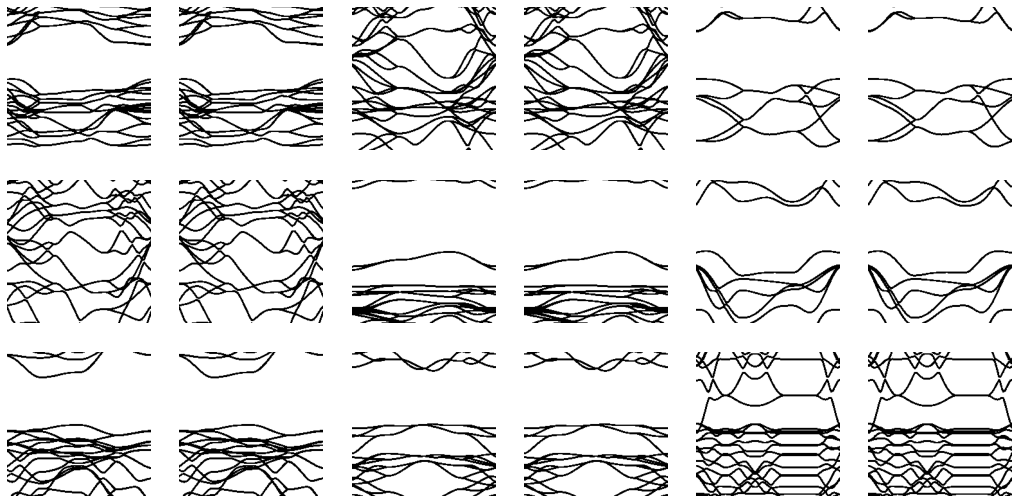

In [54]:
IMAGE_SIZE = 224
#Z_DIM = IMAGE_SIZE / 32 * Z_CHANNELS

dls = DataBlock(
    blocks=(ImageBlock(cls=PILImageNoised), ImageBlock), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    item_tfms=[Resize((IMAGE_SIZE))],
    batch_tfms=[Binarize(), RandomErasingTransform()]
        ).dataloaders(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3", bs=32)

dls.show_batch()

xb, yb = dls.one_batch()
xb.shape

## Train

### Create Learner

In [8]:
def log_cosh_loss(pred, targ, a):
    loss = (1/a) * torch.log(torch.cosh(a*(pred-targ)))
    
    return loss.mean()

In [9]:
class ResidualLayer(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, 1)
    def forward(self, x):
        return x + self.conv(x)

z_channels: 2


epoch,train_loss,valid_loss,time
0,0.557645,0.469742,00:31
1,0.439480,0.427768,00:31
2,0.412700,0.423416,00:31
3,0.405160,0.493592,00:30
4,0.394442,0.397109,00:32
5,0.377918,0.397557,00:31
6,0.370515,0.359351,00:30
7,0.356421,0.512940,00:29
8,0.352588,0.343111,00:30
9,0.342620,0.333488,00:30


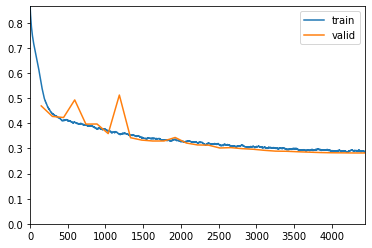

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbf02abd430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbf02abd430>assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionErrorTraceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
:     self._shutdown_workers()can only test a child process

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

z_channels: 1


epoch,train_loss,valid_loss,time
0,0.519561,0.471899,00:30
1,0.441079,0.423632,00:30
2,0.420338,0.411485,00:30
3,0.405767,0.412601,00:30
4,0.405894,0.442948,00:30
5,0.404075,0.403861,00:29
6,0.399501,0.425906,00:30
7,0.400173,0.442106,00:30
8,0.392890,0.386711,00:30
9,0.391313,0.421711,00:30


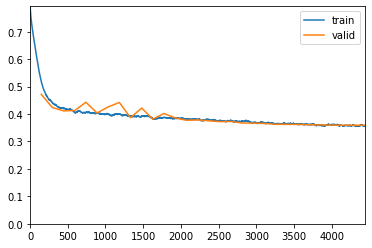

torch.Size([32, 1, 7, 7])


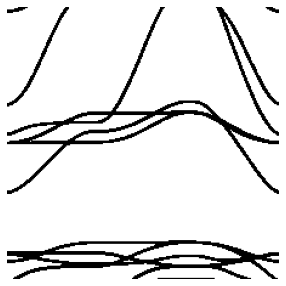

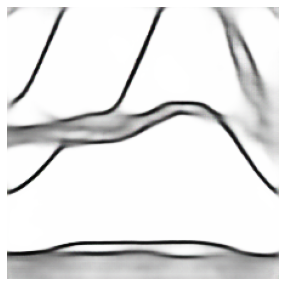

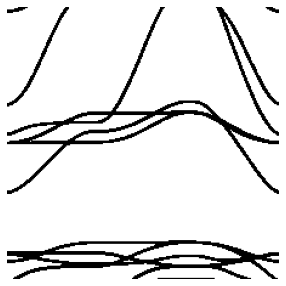

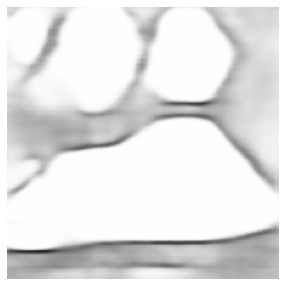

In [57]:
# for arch in ["resnet18"]:
# loss = F.mse_loss
# loss = partial(log_cosh_loss, a=1)
loss = nn.BCEWithLogitsLoss()
sigmoid = True
if isinstance(loss, nn.BCEWithLogitsLoss):
    sigmoid = False
Z_CHANNELS = 2

Z_CHANNELS_ARRAY = [2, 1]

for Z_CHANNELS in Z_CHANNELS_ARRAY:
    print("z_channels:", Z_CHANNELS)
    ae = model.BuildAutoEncoder("resnet18", sigmoid=sigmoid, z_channels=Z_CHANNELS)
    # list(ae.encoder.conv5.children())[1].relu = nn.Sequential(nn.ReLU())
    learn = Learner(dls, ae, loss, cbs=[ShowGraphCallback()])
    learn.fit_one_cycle(30)
    show(5)
    learn.export(f"trained_models/resnet18_size{IMAGE_SIZE}_lossbce_channels{Z_CHANNELS}.pkl")
    

xb, yb = dls.valid.one_batch()
# print(arch)
print(learn.model.encoder(xb.cuda()).shape)

## Save and Load Learner

In [58]:
# learn.export(f"trained_models/resnet18_size{IMAGE_SIZE}_lossbce_channels{Z_CHANNELS}.pkl")
learn = load_learner("trained_models/resnet18_size224_lossbce_channels2.pkl")
# out = learn.predict(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/2dm-1.png")
# show_image(out[1])

## View Predictions

In [59]:
from ipywidgets import interact

train = False

def show(i):
    if train:
        dl = dls.train
    else:
        dl = dls.valid
    xb, yb = dl.one_batch()
    learn.cuda()
    preds = learn.model(xb)
    if not sigmoid:
        preds = torch.sigmoid(preds)
    show_image(xb[i])
    show_image(preds[i])
    
    if train:
        show_image(yb[i])
    # print(learn.model.encoder(xb.cuda()).shape)

    

interact(show, i=(0, len(xb)-1))

interactive(children=(IntSlider(value=15, description='i', max=31), Output()), _dom_classes=('widget-interact'…

<function __main__.show(i)>

In [63]:
from ipywidgets import interact


if train:
    dl = dls.train
else:
    dl = dls.valid
dls.shuffle=False
xb, yb = dls.one_batch()

def show(i):
    print(dl.items[i])
    learn.cuda()
    preds = learn.model(xb)
    if not sigmoid:
        preds = torch.sigmoid(preds)
    show_image(xb[i])
    show_image(preds[i])
    
    if train:
        show_image(yb[i])
    # print(learn.model.encoder(xb.cuda()).shape)

    

interact(show, i=(0, len(xb)-1))

interactive(children=(IntSlider(value=15, description='i', max=31), Output()), _dom_classes=('widget-interact'…

<function __main__.show(i)>